In [1]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import wget
from datasets import load_dataset

import torch 
import torch.nn as nn 
from torch.nn import functional as F

from gpt_functions import *
from tokenizer_functions import *

torch.manual_seed(42)
g = torch.Generator().manual_seed(42)


c:\Users\jean-\OneDrive\Bureau\Projects\makemore\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

1. Removed unecessary columns: *artists*, *link* and *id*
  
There is a total of 1821 poems written by 56 artists. Therefore we have in average 32 poems per author and cannot incorporate author specific poems, which is why we disregard this variable.

In [2]:
ds = load_dataset("manu/french_poetry")
length = ds["train"].num_rows
ds

DatasetDict({
    train: Dataset({
        features: ['title', 'poet', 'text', 'link', 'id'],
        num_rows: 1821
    })
})

In [3]:
df = []
df_text = []

for i in range(length):

    poem = ds["train"]["text"][i]
    cleaned_poem = poem_formatting(poem)
    df.append(cleaned_poem) # add the title and the poem
    df_text.append(cleaned_poem[1]) # add only the poem

concatenated_text = "".join(df_text)

In [4]:
value = 0

for i in range(len(df_text)):
    value += len(df_text[i])

print(f"The total number of string in the poem is {value}, so an average of {value/length:.2f} words per poems")

The total number of string in the poem is 2682648, so an average of 1473.17 words per poems


### Preprocessing 

1. Download Data
2. Retrieve list characters

In [5]:
# Download with Windows command 
!curl -o input.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# Read txt
with open("input.txt", "r", encoding= "utf-8") as f:
    text = f.read()
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1089k  100 1089k    0     0  6947k      0 --:--:-- --:--:-- --:--:-- 7027k


In [6]:
# Retrieve characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


----------

In [20]:
print(f" There is a total of {len(list(set(concatenated_text.split())))} vocabulary words in the dataset.")
tokenizer = BasicTokenizer()

vocab_size = (list(set(concatenated_text.split())))

vocab_size

 There is a total of 57075 vocabulary words in the dataset.


['négresse',
 'Colorent',
 'Calmes,',
 'reître,',
 'vilaines',
 'Etna',
 "Qu'ainsi",
 "s'ajoute",
 'aimables',
 'médianoche,',
 "D'ailleurs",
 'attristante,',
 'camus',
 'triomphale,',
 'valeur,',
 'tournez',
 'robinsonne',
 'proie.',
 'Ira',
 'Statue',
 'Redescendent',
 'muet.RÉCITATIF',
 'paresse.',
 'mécréant',
 'Acceptez-la',
 'glaces',
 'vénérables',
 'su,',
 'papaux,',
 'grande',
 'Sors-tu',
 'bouquet,',
 'rouges-gorges,',
 'amplement,',
 'Deuxième',
 "d'eau-de-vie",
 'penseur',
 'B',
 'aspirait',
 'matin',
 'profonde,',
 'absous,',
 'frénésie',
 'fourni',
 'Arrive',
 'piment',
 'Montaigne',
 'normande',
 'Providence,',
 'déposons',
 'taberna',
 'disent,',
 'décembre.Nos',
 'sérieuse,',
 'nourrice,',
 'Abonder',
 "l'infini,",
 'Corbière',
 'bavardiez,',
 'boule',
 "m'intéresse",
 "l'insecte,",
 '(mon',
 'reine,',
 'Probité,',
 'Descendrons-nous',
 'Littéral,',
 'déshérité.',
 'jette,',
 'cachera',
 'faites-',
 'pain',
 'étoilés',
 'ventrus,',
 'Bismarck,',
 'redresser',
 'Alcandr

In [21]:
tokenizer.train(concatenated_text, vocab_size=1000)
tokenizer.encode("hello world") # string -> tokens
tokenizer.decode([1000, 2000, 3000]) # tokens -> string
tokenizer.save("mymodel") # writes mymodel.model and mymodel.vocab
tokenizer.load("mymodel.model") # loads the model back, the vocab is just for vis

KeyboardInterrupt: 

-----

### Building Model

  1. Basic encoder-decoder
  2. Separate in training and evaluation

In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars)}
itos = { i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda s: [itos[c] for c in s]

print(encode("hii there"))
print(decode(encode("hii there")))

# Encode data 
data = torch.tensor(encode(text), dtype = torch.long)
print(data.shape, data.dtype)

# Encode with personal tokenizer
data_tok = torch.tensor(tokenizer.encode(text), dtype = torch.long)

[46, 47, 47, 1, 58, 46, 43, 56, 43]
['h', 'i', 'i', ' ', 't', 'h', 'e', 'r', 'e']
torch.Size([11]) torch.int64


In [ ]:
# Separate into train and evaluation
n = int(0.9 * len(data))
train_data = data[:n]   # 90% training
val_data = data[n:]     # 10% evaluation

### Model Training

1. Hyperparameters & Model
   

In [ ]:
config_GPT = GPTConfig(
    vocab_size=vocab_size,
    block_size=128,
    n_embd=200,
    n_head=4,
    n_layer=4,
    batch_size = 32,
    max_steps = 1000,
    eval_iter = 100,
    eval_interval = 10,
    learning_rate = 1e-3,
    dropout=0.2,
    device='cuda',
)

In [ ]:
model = GPTLanguageModel(config_GPT).to(config_GPT.device)
optimizer = torch.optim.AdamW(model.parameters(), lr = config_GPT.learning_rate)

print(f"The Model has a total of {sum(p.numel() for p in model.parameters())/1e6:.2f} M parameters")

The Model has a total of 1.98 M parameters


In [ ]:
@torch.no_grad()
def estimate_loss(config_GPT):
    out = {}
    model.eval()
    for split, data_loss in [("train", train_data), ("val", val_data)]:

        losses = torch.zeros(config_GPT.eval_iter)
        for k in range(config_GPT.eval_iter):
            X,Y = get_batch(data_loss,config_GPT.block_size, config_GPT.batch_size, config_GPT.device)
            logits, loss = model(X,Y)
            losses[k] = loss.item()        
        out[split] = losses.mean().item()
    model.train()

    return out


In [ ]:
estimate_loss(config_GPT)

RuntimeError: random_ expects 'from' to be less than 'to', but got from=0 >= to=-119

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
train_loss = []
eval_loss = []

for iter in range(config_GPT.max_steps):

    # every once in a while evaluate the loss on train and val sets
    if iter % config_GPT.eval_interval == 0 or iter == config_GPT.max_steps - 1:
        losses = estimate_loss(config_GPT)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_loss.append(losses["train"])
        eval_loss.append(losses["val"])

    # sample a batch of data
    xb, yb = get_batch(train_data,config_GPT.block_size, config_GPT.batch_size, device = config_GPT.device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.2245, val loss 4.2228
step 10: train loss 3.2105, val loss 3.2638
step 20: train loss 2.8214, val loss 2.8314
step 30: train loss 2.6797, val loss 2.6738
step 40: train loss 2.6009, val loss 2.6099
step 50: train loss 2.5544, val loss 2.5525
step 60: train loss 2.5257, val loss 2.5251
step 70: train loss 2.5079, val loss 2.5017
step 80: train loss 2.4956, val loss 2.4961
step 90: train loss 2.4789, val loss 2.4824
step 100: train loss 2.4669, val loss 2.4796
step 110: train loss 2.4542, val loss 2.4674
step 120: train loss 2.4519, val loss 2.4789
step 130: train loss 2.4401, val loss 2.4510
step 140: train loss 2.4275, val loss 2.4406
step 150: train loss 2.4086, val loss 2.4207
step 160: train loss 2.4047, val loss 2.4188
step 170: train loss 2.3731, val loss 2.3821
step 180: train loss 2.3873, val loss 2.3942
step 190: train loss 2.3275, val loss 2.3536
step 200: train loss 2.3219, val loss 2.3419
step 210: train loss 2.2737, val loss 2.3087
step 220: train loss 

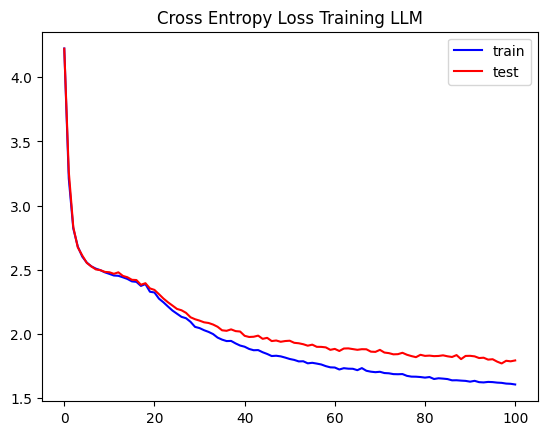

In [ ]:
plt.plot(train_loss, color = "blue", label = "train")
plt.plot(eval_loss, color = "red", label = "test")
plt.legend()
plt.title("Cross Entropy Loss Training LLM")
plt.show()

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device = config_GPT.device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

['\n', 'T', 'h', 'i', 's', ' ', 'p', 'r', 'e', 's', 'u', 'r', 'i', 'e', 's', 't', ' ', 'd', 'e', 'a', 'r', ' ', 'e', 'f', 'e', 'n', 't', ' ', 'a', 'n', 'd', ' ', 'p', 'l', 'u', 'l', ' ', 'n', 'o', 'w', '.', '\n', '\n', 'T', 'H', 'O', 'M', 'f', ' ', 'G', 'r', 'o', 'n', 'o', 'u', 't', ',', '\n', "'", 'C', 'A', 'R', 'I', 'O', 'N', ':', '\n', 'F', 'e', 'c', 't', ' ', 'k', 'I', ':', '\n', 'B', 'y', ' ', 'a', 'l', 'l', ' ', 'k', 'i', 'n', 'g', 's', ' ', 'm', 'y', ' ', 'm', 'e', ' ', 'i', 's', '.', '\n', '\n', 'R', 'O', 'M', 'E', 'O', ':', '\n', '\n', 'I', 'S', 'A', 'B', 'E', 'L', 'L', 'A', ':', '\n', 'W', 'h', 'e', 'r', 'e', 'a', 't', ' ', 'a', 'r', 'm', ',', ' ', 't', 'h', 'i', 'n', 'k', ' ', 't', 'h', 'e', ' ', 'a', 't', ' ', 'l', 'o', 'r', 'd', 's', ':', '\n', 'B', 'u', 't', ' ', 't', 'h', 'e', ' ', 'h', 'a', 't', 'c', 'h', ' ', 'a', ' ', 'f', 'i', 'e', 'd', ' ', 'd', 'o', 'o', 'l', 'a', 's', 'i', 'n', "'", 's', ' ', 'o', 'f', ' ', 'm', 'a', 's', 't', 'e', 'r', ',', '\n', 'T', 'h', 'e', '